## SCRIMP: Partitioned Finite Element Method (PFEM) for port-Hamiltonian systems with boundary damping: anisotropic heterogeneous heat equation in two dimensions

<b>Goal</b>: This <a href="https://jupyter.org"> Jupyter</a> notebook aims at illustrating the use of the Partitioned Finite Element Method (PFEM) to discretize a port-Hamiltonian system related to the two-dimensional heat equation. We specifically learn how to define the problem inside SCRIMP. This notebook is related to the companion paper "Anisotropic heterogeneous n-D heat equation with boundary control and observation: II. Structure-preserving discretization" by A. Serhani, D. Matignon and G. Haine, (2019). 

<b>Note</b>: a cell is made active by first clicking on the left part of the web page (a blue vertical line appears) and then pushing Shift+Enter. 

<b>Note</b>: The next cell has to be activated only once and specifies the Python libraries we will use in this notebook. A basic knowledge of Python is only expected to understand the code used in the cells.  

In [1]:
#
# To allow plots within the Notebook 
#
%matplotlib inline

# Import here the standard Python libraries used in the Notebook
import matplotlib.pyplot as plt

import numpy as np
from scipy import linalg, show_config
import sys 
import time

from dolfin import *
from mshr import *


# Import here the classes related to SCRIMP
from Heat import Heat_2D


Could not find GLIMDA.


### Python version

In [2]:
print(sys.version)

3.7.3 | packaged by conda-forge | (default, Mar 27 2019, 15:43:19) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


### <a href="https://fenicsproject.org">FEniCS</a> version 

In [3]:
print(dolfin.__version__)

2019.1.0


### <a href="https://fenicsproject.org">Scipy</a> Linear algebra libraries

In [4]:
print(show_config())

mkl_info:
  NOT AVAILABLE
lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
    libraries = ['blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack']
    library_dirs = ['/Users/vasseur/Software/anaconda3/envs/fenicsproject/lib']
    language = f77
lapack_opt_info:
    libraries = ['blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack']
    library_dirs = ['/Users/vasseur/Software/anaconda3/envs/fenicsproject/lib']
    language = f77
blas_mkl_info:
  NOT AVAILABLE
system_info:
  NOT AVAILABLE
openblas_info:
    libraries = ['blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack']
    library_dirs = ['/Users/vasseur/Software/anaconda3/envs/fenicsproject/lib']
    language = f77
blas_opt_info:
    libraries = ['blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack']
    library_dirs = ['/Users/vasseur/Software/anaconda3/envs/fenicsproject/lib']
    language = f77
None


# Anisotropic heterogeneous 2D heat equation with boundary control and observation:


We consider the two-dimensional heterogeneous anisotropic heat equation defined for all $t\ge 0$ as
$$
\begin{array}{ll} 
    \rho(\boldsymbol x)\, C_V(t,\boldsymbol x) \displaystyle \frac{\partial}{\partial t} T(t,\boldsymbol x) &=& \text{div}\Big(\overline{\overline \lambda}(\boldsymbol x)\cdot\textbf{grad} \ T(t,\boldsymbol x)\Big), \quad \boldsymbol x \in \Omega, \\
    Z(\boldsymbol x)~(\overline{\overline T}(\boldsymbol x)\cdot\textbf{grad} \ w(t,\boldsymbol x)) \cdot {\bf{n}} + 
    {\partial_t} T(t,\boldsymbol x) & = & 0,      \quad \boldsymbol x \in \partial \Omega, \\ 
    T(0, \boldsymbol x)             & = & T_0(x), \quad \boldsymbol x \in \Omega, t=0 \\
\end{array}
$$
with $\Omega \subset \mathbb{R}^2$ an open bounded spatial domain with Lipschitz-continuous boundary $\delta \Omega$. 

$T(t,\boldsymbol x)$ denotes the temperature at point $\boldsymbol x \in \Omega $ and time $t$. $\rho \in L^{\infty}(\Omega)$ (positive and bounded from below) denotes the mass density, $\overline{\overline \lambda} \in L^{\infty}(\Omega)^{2\times 2}$ (symmetric and coercive) the thermal conductivity. 


<b>Structure of this part</b>: This notebook first defines the continuous problem by using a specific class of SCRIMP related to the heat equation in two dimensions. Then we tackle the discretization in space of the port-Hamiltonian system through the PFEM methodology. This discretization leads to a DAE formulation. After time discretization, we perform a numerical simulation to obtain an approximation of the space-time solution. Finally a simple postprocessing is performed. 

### Class object related to the PDE heat equation

In [5]:
H = Heat_2D()

### Constants and parameters 

In [6]:
#
# Define constants related to the definition of the geometric rectangular domain
#
x0, xL, y0, yL = 0., 2., 0., 1.
#
# Define constants related to the time discretization [tclose is set but not used here]
#
tinit  = 0.
tfinal = 2.
tclose = 2.
#
# Define the parameters related to the time discretization [theta is set but not used here]
# 
dt     = 1.e-2
theta  = 0.5
#
# Specify the method to be used for the time integration
#
time_method = 'ODE:Assimulo'

### FEniCS expressions definition

In [7]:
#
# Define Fenics Expressions 
#

# Mass density (TBC: role of xL in this expression)
Rho    = 'x[0]* (2.-x[0])+ x[1]* (1.-x[1]) + 1'

# Thermal conductivity 
T11    = '5. + x[0]*x[1]'
T12    = '(x[0]-x[1])*(x[0]-x[1])'
T22    = '3.+x[1]/(x[0]+1)'

# Isochoric heat capacity
Cv      = '3.'
  
# Initial conditions    
amplitude, sX, sY, X0, Y0  = 3., (xL-x0)/12., (yL-y0)/12., (xL-x0)/2., (yL-y0)/2. 
T0     = 'amplitude * exp(- pow( (x[0]-X0)/sX, 2) - pow( (x[1]-Y0)/sY, 2) )'
Fq_0_1 = '0'
Fq_0_2 = '0'
Eq_0_1 = '0'
Eq_0_2 = '0' 

# Boundary control function that controls the time derivative on the whole boundary  
# Geometrical part as a FEniCS expression
boundary_cntrl_space = 'x[0] + x[1]'

# Time part of the control defined as a pure Python function
def boundary_cntrl_time(t,close_time):
    """
    Specify here the time part of the boundary control as a pure Python function 
    """        
    if t <= close_time:
        return 2.*t/(t+1.)
    else:
        return 0.

### Problem at the continuous level

In [8]:
#
# Problem definition at the continous level
#
   
# Select the domain as a rectangular domain of shape [x0, xL] x [y0, yL]    
H.Set_rectangular_domain(x0, xL, y0, yL)
 
# Specify the physical parameters    
H.Set_physical_parameters(Rho, T11, T12, T22)
    
# Specify the isochoric heat capacity
H.Set_isochoric_heat_capacity(Cv)
  
# Specify the initial conditions related to [TBC]
    
# Specify the boundary control function (space) 
H.Set_boundary_cntrl_space(boundary_cntrl_space)

# Specify the boundary control function (time)
# If nothing is specified, the control is only space dependent
# otherwise it corresponds to the product of the two space and time functions.
H.Set_boundary_cntrl_time(boundary_cntrl_time)

# Specify the initial, closing and final time
H.Set_initial_close_final_time(tinit,tclose,tfinal)
   
# Check    
assert H.Check_Problem_Definition() == 1, "Problem definition to be checked again !"

### Problem at the discrete level in space and time

In [9]:
#
# Finite Element Space and Time discretization of the weak formulation
# 
  
# Generate the computational mesh with rfn as a refinement parameter on the whole boundary    
H.Generate_mesh(rfn=4)
    
# Select the FE approximation spaces of Raviart-Thomas type
H.Set_FE_Approximation_Spaces(family_q='RT', family_p='P', family_b='P', family_l='P',\
                              rt_order=1, p_order=2, b_order=2, l_order=2)
    
# Discretization in space of the weak formulation with PFEM    
H.Apply_PFEM_formulation()
  
# Interpolate the initial data on the appropriate FE spaces
H.Project_initial_data_FE_spaces(T0, Fq_0_1, Fq_0_2, Eq_0_1, Eq_0_2,   
                                 amplitude  = Constant(amplitude), 
                                 sX=Constant(sX), sY=Constant(sY),
                                 X0=Constant(X0), Y0=Constant(Y0))
   
# Specify the parameters related to the time discretization
H.Set_time_setting(dt, theta, time_method)
 
# Check
assert H.Check_Space_Time_Discretization() == 1, "Space and time discretization to be checked again !"

### Numerical approximation of the space-time solution

In [10]:
#
# Numerical Approximation of the space-time solution
#
Ham, t_span = H.Time_integration(time_method)

ODE Integration using assimulo built-in functions:
Final Run Statistics: --- 

 Number of steps                                 : 68
 Number of function evaluations                  : 87
 Number of Jacobian*vector evaluations           : 307
 Number of function eval. due to Jacobian eval.  : 307
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 83
 Number of nonlinear convergence failures        : 3

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : SPGMR
 Maximal order            : 3
 Tolerances (absolute)    : 0.001
 Tolerances (relative)    : 0.001

Simulation interval    : 0.0 - 2.0 seconds.
Elapsed simulation time: 0.6730187639999983 seconds.


In [11]:
time_method   = 'DAE:Assimulo'
H.Set_time_setting(dt, theta, time_method)
Ham_dae, t_span_dae = H.Time_integration(time_method) 

DAE Integration using assimulo built-in functions:
Final Run Statistics: --- 

 Number of steps                                 : 129
 Number of function evaluations                  : 171
 Number of Jacobian evaluations                  : 19
 Number of function eval. due to Jacobian eval.  : 11191
 Number of error test failures                   : 5
 Number of nonlinear iterations                  : 171
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                       : IDA (BDF)
 Maximal order                : 5
 Suppressed algebr. variables : True
 Tolerances (absolute)        : 1e-06
 Tolerances (relative)        : 1e-06

Simulation interval    : 0.0 - 2.0 seconds.
Elapsed simulation time: 6.55648261 seconds.
Final Run Statistics: --- 

 Number of steps                                 : 129
 Number of function evaluations                  : 171
 Number of Jacobian evaluations                  : 19
 Number of function eval. due to Jacobian eval.  :

In [12]:
time_method   = 'DAE:Assimulo:Lagrangian'
H.Set_time_setting(dt, theta, time_method)
Ham_dae_l, t_span_dae_l = H.Time_integration(time_method) 

DAE Integration using assimulo built-in functions:
Final Run Statistics: --- 

 Number of steps                                 : 161
 Number of function evaluations                  : 207
 Number of Jacobian evaluations                  : 25
 Number of function eval. due to Jacobian eval.  : 3725
 Number of error test failures                   : 7
 Number of nonlinear iterations                  : 207
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                       : IDA (BDF)
 Maximal order                : 5
 Suppressed algebr. variables : True
 Tolerances (absolute)        : 1e-06
 Tolerances (relative)        : 1e-06

Simulation interval    : 0.0 - 2.0 seconds.
Elapsed simulation time: 0.4913559939999992 seconds.
Final Run Statistics: --- 

 Number of steps                                 : 161
 Number of function evaluations                  : 207
 Number of Jacobian evaluations                  : 25
 Number of function eval. due to Jacobian e

### Post-processing

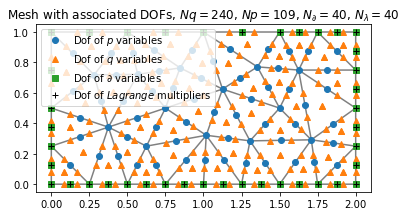

In [13]:
# Specify the mode
H.notebook = True

# Plot of the mesh with corresponding DOFs
H.plot_mesh_with_DOFs()    

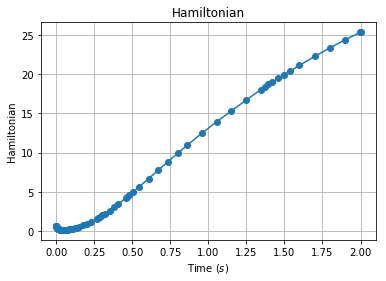

In [14]:
# Plot of the Hamiltonian function versus time
H.plot_Hamiltonian(t_span, Ham, marker='o', label='ODE')

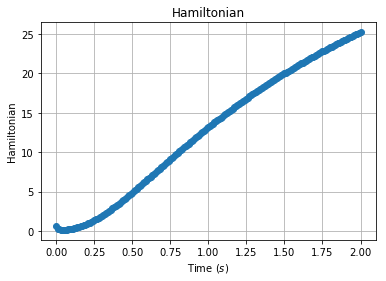

In [15]:
# 
H.plot_Hamiltonian(t_span_dae,Ham_dae, marker='o', label='DAE')

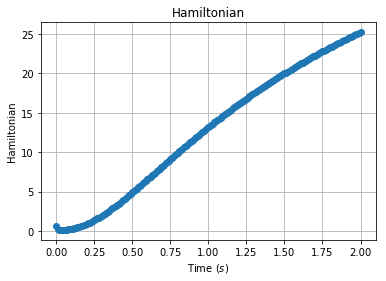

In [16]:
# 
H.plot_Hamiltonian(t_span_dae_l,Ham_dae_l, marker='o', label='DAE:Lagrange')

In [17]:
# Movie shown in a new window 

movie = False

if movie:
    %matplotlib tk
    W.set_video_writer()
    W.moving_trisurf(Deflection,1,'Deflection_versus_time',save=True)
    %matplotlib inline

## Notes

### Your comments or notes

# Further information

- "Anisotropic heterogeneous n-D heat equation with boundary control and observation: II. Structure-preserving discretization" by A. Serhani, D. Matignon and G. Haine, (2019).
